In a [previous post](/posts/butane_leak_example/) I worked through estimating the airborne quantity of butane due to a leak from a storage sphere. That example stopped at estimating the total quantity released, here I would like to go further into the potential for a vapour cloud explosion.

As a recap the scenario is a leak from a butane storage sphere, the leak is 10ft above grade and results in cloud of mostly aerosolized butane that is initially below ambient temperature. The scenario parameters and results are summarized below.

As a quick note, the whole purpose of this exercise is a sort of high-level hazard screening. Detailed enough to decide whether or not the consequences of a hazard warrant more detailed modeling.

In [1]:
#| output: false

using Plots
using Unitful
using Interpolations
using CSV
using DataFrames

gr()

ft = ustrip(u"m", 1u"ft")     # unit conversion ft->m
inch = ustrip(u"m", 1u"inch") # unit conversion inch->m
psi = ustrip(u"Pa", 1u"psi")  # unit conversion psi->Pa

6894.757293168361

In [2]:
#| output: false

# Scenario parameters
hᵣ = 10ft       # height of release point, m
pₐ= 14.7psi     # atmospheric pressure, Pa
Tₐ= 25 + 273.15 # the ambient temperature, K
td = 10*60      # release duration, 10 minutes, s

# Constants
R = 8.31446261815324 # universal gas constant, J/mol/K
g = 9.806            # acceleration due to gravity, m/s2

# Properties of Butane, from Perry's or DIPPR
Mw = 58.122    # molar weight kg/kmol
ρₗ(T) = Mw*( 1.0677/0.27188^(1+ (1-T/425.12)^0.28688) ) # density liquid, kg/m3
ρg(T) = (pₐ*Mw)/(R*T)/1000 # density gas, ideal gas law, kg/m3
ΔHc = 2657.320 # heat of combustion, kJ/mol
LFL = 1.86e-2  # lower flammability limit, vol/vol

# Properties of Air
MWₐᵢᵣ = 28.960                  # molar weight air, kg/kmol
ρa(T) = (pₐ*MWₐᵢᵣ)/(R*T)/1000   # density of air, ideal gas law, kg/m^3

# Calculated previously
Tc = -0.6 + 273.15       # cloud temperature, K
fᵥ = 0.17128269541302374 # flashed fraction
fₐ = 0.9227949810754577  # aerosol fraction

Qaq = 52.82002170865257 # airborne quantity, kg/s


52.82002170865257

This example focuses on a next step in a standard hazard screening, namely estimating the scale of a potential vapour cloud explosion. Typically, for flammable gases, the potential for a vapour cloud explosion is the worst case outcome of a release.

## Vapour Cloud Dispersion

The first step in determining the consequences of a vapour cloud explosion is to estimate the size of the vapour cloud that could take part in the explosion. This is generally done through some sort of dispersion modeling. There are many ways of defining the portion of the vapour cloud that can explode, in this case I am going to assume the flammable portion of the cloud is that with a concentration $\ge \frac{1}{2} LFL$ .

There is a fair bit of discussion in the literature as to whether to use the LFL or 1/2 LFL, using half the LFL is, at the very least, more conservative and given the simplified methods I am using to estimate the size of the cloud it is probably best to err on the side of an overly large cloud.

### Atmospheric Stability and Wind Profile

Prior to determining the particular dispersion model some meteorological parameters must be decided upon. Atmospheric stability and the wind profile define the extent of vertical mixing, which governs how large the cloud can grow and how dispersed the butane, in this case, will get during the release. They are also important in the decision criteria for which type of dispersion model to use.

In general, the worst case atmospheric stability is the most stable, Pasquill stability class F, for neutral to negatively buoyant clouds at ground level. This limits the degree of mixing and leads to a larger explosive mass, since we define the explosive mass as the portion of the cloud greater than half the lower flammability limit. If the cloud mixes thoroughly with the air it will be dispersed to levels well below the LFL and thus cannot explode

For this scenario I am supposing *class F* stability and a moderate windspeed of *3m/s* at the release point.

There are two other important wind-speeds that will be needed, the *friction velocity*, $u_{\star}$, and the wind-speed at the standard elevation of 10m, $u_{10}$ which can be obtained from the wind profile. The wind profile can be estimated using a power law distribution parameterized based on the Pasquill stability class.

$$ {u \over u_r} = \left( h \over h_r \right)^p $$

Where the parameter *p* is tabulated[@ccps-1999 page 83] here

| Stability | urban | rural | 
|:---------:|:-----:|:-----:| 
| A         | 0.15  | 0.07  | 
| B         | 0.15  | 0.07  | 
| C         | 0.20  | 0.10  | 
| D         | 0.25  | 0.15  | 
| E         | 0.40  | 0.35  | 
| F         | 0.60  | 0.55  |


There are several ways to estimate the friction velocity, but a simple rule of thumb used in the EPA TSCREEN model is to assume

$$ u_{\star} = 0.06 u_{10} $$

This is a very simplified approach and there are many alternatives to calculating the friction velocity, and parameterizing the atmospheric stability. For the purposes of this simple example this is fine but it is an opportunity for future refinement of the hazard screening.


In [3]:
# wind profile
uᵣ = 3.0     # the wind-speed at release height, m/s
p = 0.55     # parameter, pasquill stability class F

u(h) = uᵣ*(h/hᵣ)^p

u₁₀ = u(10)

u₊ = 0.06 * u₁₀

0.3459905806850393

### Release Type

The first important decision is whether to model the release as a continuous plume or an instantaneous puff. In reality the answer is neither but these limiting cases are easier to model and are used as first approximations.

A simple rule of thumb is that if the distance traveled by a parcel of air over the release duration is greater than 2.5 times the distance to the point of interest, then the release can be modeled as continuous, otherwise it would be treated as instantaneous.

$$ 2.5 \le { u_r t_d \over x^{\star} } $$

Roughly speaking if the plume is still attached to the release point when the leading edge hits the downwind point of interest then it looks like a continuous plume to an observer at this point.

This can be used to define a critical distance, such that any distance *less* than that is best modeled by a continuous release and any distance greater is best modeled by an instantaneous release. This is useful as the downwind distance is, as of yet, unknown. The distance to half the LFL concentration, which defines the extent of the cloud involved in the explosion, depends upon which model is used and is in fact one of the key parameters we need to solve for.

In [4]:
x⁺ = uᵣ*td/2.5

720.0

From prior experience, the distance to 1/2 LFL will likely be &lt;~200m and so a continuous release can be assumed. If after performing the calculation the downwind distance turns out to be greater than 720m then this can be re-assessed.

### Dense Gas Dispersion

The second critical factor for determining which model to use is whether or not the cloud is significantly denser than air. Dense clouds slump and hug the ground to a far greater extent than neutrally buoyant clouds and models for neutral clouds can lead to significant overestimations of the size of the vapour cloud when used on a dense cloud.

The relevant parameter for determining if a dense gas dispersion model should be used is the Richardson number, the ratio of the potential energy from the excess density to the kinetic energy from ambient turbulence. The Richardson number for continuous releases is defined as[@ccps-1996 page 50]


$$ \mathrm{Ri} = { { g_o V_r } \over { D_c u_{\star} } } $$

where

$$ g_o = g { {\rho_c - \rho_a } \over \rho_a } $$

with $\rho_c$ the density of the cloud and $\rho_a$ the density of the ambient air. $V_r$ is the volumetric release rate, and $D_c$ a critical distance, in this case we take $D_c$ to be the release height.

The density of the cloud is significantly larger than the vapour density of butane as the cloud has a large fraction of aerosolized droplets, overall the cloud density can be estimated by

$$ \frac{1}{\rho_c} = { f_v \over \rho_g } + { \left(1 - f_v \right) f_a \over \rho_l }$$

The critical Richardson number is about 50 such that if the Richardson number is greater than 50 then a dense gas model must be used.

In [5]:
ρc(T) = ((fᵥ/ρg(T)) + ((1-fᵥ)*fₐ/ρₗ(T)))^-1

gₒ = g * ((ρc(Tc) - ρa(Tₐ))/ ρa(Tₐ))

Vr = Qaq/ρc(Tc)

Ri = (gₒ * Vr)/(hᵣ * u₊)

381.8214520915426

In [6]:
Ri > 50

true

This suggests that a dense gas model should be used, which conforms to our expectations as the vapour cloud is significantly denser than the ambient air.

An additional check is to use the criteria from @britter-1988


$$ \left( g_o V_r \over { u_{10}^3 D} \right)^{1/3} \ge 0.15 $$

Where $D$ is a critical distance defined as

$$ D = \sqrt{ V_r \over u_{10} } $$

In [7]:
D = √(Vr/u₁₀)

( (gₒ * Vr) / (u₁₀^3 * D) )^(1/3) ≥ 0.15

true

### Britter-McQuaid model

The Britter-McQuaid model[@britter-1988] is a dense cloud dispersion model based on dimensional analysis and fitting to experimental data. It is given as a series of correlation curves for six different concentrations and the distance to the concentration of interest is interpolated from these. The concentrations represent a mean concentration over the whole cloud at that distance.

This is one of the simpler models to use directly, and is appropriate for a screening case. Dense gas dispersion modeling is a large field with many different models that could be used and, like many things, as the models grow in detail they also grow in the number of parameters that must be provided. For the purposes of screening the limiting factor is often not computing power or model complexity *per se* as much as the information required to even run the models and the time needed to gather that information.

*Note* the concentrations in this model are given in volume fraction and it is assumed that the in-cloud concentration of butane is 1.0 (i.e 100%) at the release point.

The Britter-McQuaid curves can be approximated with a series of piece-wise linear functions[@ccps-2000]


$$ \beta = m \alpha + b $$

In [8]:
function piecewise(α; αs, ms, bs)
    i = findnext(x -> x > α, αs, 1)
    return ms[i]*α + bs[i]
end

function piecewise(; αs, ms, bs)
    return α -> piecewise(α, αs=αs, ms=ms, bs=bs)
end


Britter_McQuaid_correlations = Dict{Float64, Function}(
    0.001 => piecewise(αs=[-0.69, -0.25, -0.13, 1.0],
                       ms=[0.00, 0.39, 0.00, -0.50],
                       bs=[2.60, 2.87, 2.77, 2.71]),
    0.005 => piecewise(αs=[-0.67, -0.28, -0.15, 1.0],
                       ms=[0.00, 0.59, 0.00, -0.49],
                       bs=[2.40, 2.80, 2.63, 2.56]),
    0.010 => piecewise(αs=[-0.70, -0.29, -0.20, 1.0],
                       ms=[0.00, 0.49, 0.00, -0.52],
                       bs=[2.25, 2.59, 2.45, 2.35]),
    0.020 => piecewise(αs=[-0.69, -0.31, -0.16, 1.0],
                       ms=[0.00, 0.45, 0.00, -0.54],
                       bs=[2.08, 2.39, 2.25, 2.16]),
    0.050 => piecewise(αs=[-0.68, -0.29, -0.18, 1.0],
                       ms=[0.00, 0.36, 0.00, -0.56],
                       bs=[1.92, 2.16, 2.06, 1.96]),
    0.100 => piecewise(αs=[-0.55, -0.14, 1.0],
                       ms=[0.00, 0.24, -0.50],
                       bs=[1.75, 1.88, 1.78]),
)

Dict{Float64,Function} with 6 entries:
  0.01  => #7
  0.005 => #7
  0.02  => #7
  0.001 => #7
  0.1   => #7
  0.05  => #7

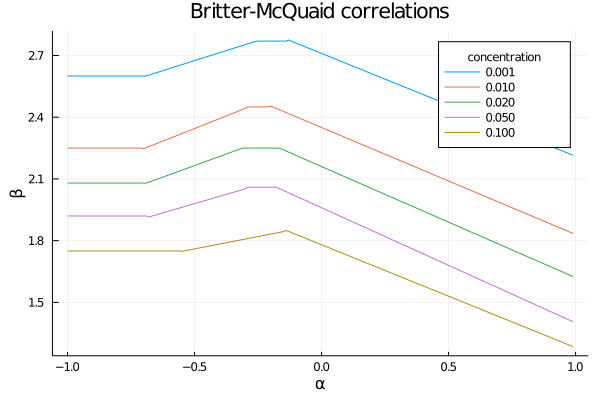

In [9]:
#| echo: false
#| label: fig-curves
#| fig-cap: "The digitized Britter-McQuaid correlation curves."

alphas = -1.0:0.01:0.99

plot(alphas, Britter_McQuaid_correlations[0.001], lab="0.001")
plot!(alphas, Britter_McQuaid_correlations[0.010], lab="0.010")
plot!(alphas, Britter_McQuaid_correlations[0.020], lab="0.020")
plot!(alphas, Britter_McQuaid_correlations[0.050], lab="0.050")
plot!(alphas, Britter_McQuaid_correlations[0.100], lab="0.100")
plot!(title="Britter-McQuaid correlations",
      ylabel="β",
      xlabel="α",
      legend=:best,
      legendtitle="concentration",
      legendtitlefontsize=8)

The correlations are given in terms of the parameters α and β, which are

$$ \alpha = 0.2 \cdot \log \left( g_o^2 V_r u_{10}^{-5} \right) $$

and 

$$ \beta = \log \left( x \over D \right) $$

At first glance it is not obvious how to use these plots, or the associated piecewise functions, since, at least to me, the obvious form of a model is to compute the concentration at a given point whereas the Britter-McQuaid model does the opposite. One supplies a concentration of interest and solves for the downwind distance where the leading edge of the plume hits this concentration.

The general procedure is:

1. Compute the parameter α for the given scenario
2. Find the concentration curves that bracket the concentration of interest
3. Calculate β at these two concentrations and interpolate to find β at the concentration of interest
4. Calculate the downwind concentration, x, from β

The function below is a convenience function that calculates the β for each concentration curve at a fixed α and returns a function that linearly interpolates to find the downwind distance for a given concentration.

In [10]:
"""
    britter_mcquaid_model(α, D; table=Britter_McQuaid_correlations)

Generate the interpolation function x(c), using the Britter-McQuaid correlations.
The system is parameterized by α and D, which are defined in the Britter-McQuaid
model documentation.

"""
function britter_mcquaid_model(α, D; table=Britter_McQuaid_correlations)
    interp_data = [ [conc, bfun(α)] for (conc, bfun) in table ]
    interp_data = hcat(interp_data...)'
    interp_data = sortslices(interp_data, dims=1)
    linterp = LinearInterpolation(interp_data[:,1], interp_data[:,2], extrapolation_bc=Line())
      
    return c -> 10^(linterp(c))*D
end

britter_mcquaid_model

In [11]:
α = 0.2*log10( gₒ^2 * Vr * u₁₀^-5 )

0.17108241842192004

In [12]:
x = britter_mcquaid_model(α, D)

#11 (generic function with 1 method)

The Britter-McQuaid model assumes an isothermal case and the following correction is suggested for non-isothermal cases

$$ C^\prime = { C \over { C + (1-C) \frac{T_a}{T_c} } }$$

In this case the concentration of interest is half the lower flammability limit and the cloud is assumed to be well below ambient conditions.

In [13]:
c = 0.5*LFL

Cᵢ = c / (c + (1 - c)*(Tₐ/Tc) )

0.008508269826866945

The down-wind distance to half the LFL can then be estimated, and checked to ensure it is within the region for which a continuous release is a reasonable approximation.

In [14]:
xᵢ = x(Cᵢ)

165.85001073807788

In [15]:
xᵢ ≤ x⁺

true

The Britter-McQuaid model also has a correlation for short distances, $x \lt 30D$

$$ C = { { 306 \left( \frac{x}{D} \right)^{-2} } \over { 1 + 306 \left( \frac{x}{D} \right)^{-2} } } $$

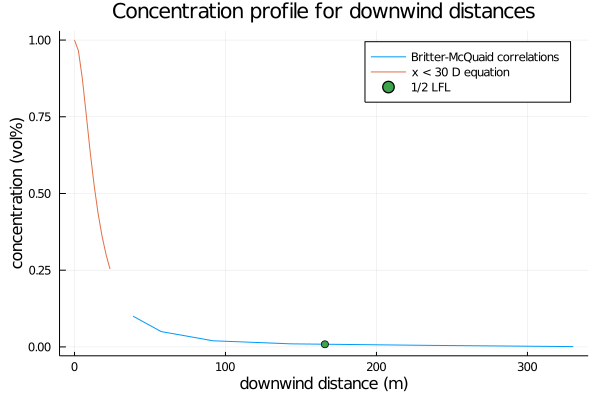

In [16]:
#| echo: false
#| label: fig-concentrations
#| fig-cap: "The Britter-McQuaid concentration curve for the example release."

Cs = [ conc for (conc, bfun) in Britter_McQuaid_correlations ]
sort!(Cs)
xs = x.(Cs)

function short_dist(x)
    x′ = x/D
    return x′ > 0 ? 306*x′^-2 / (1+ 306*x′^-2) : 1.0
end

short_xs = range(0, 30*D, length=10)
short_Cs = short_dist.(short_xs)

plot(xs, Cs, label="Britter-McQuaid correlations")
plot!(short_xs, short_Cs, label="x < 30 D equation")
plot!([xᵢ], [Cᵢ], st=:scatter, label="1/2 LFL")
plot!(title="Concentration profile for downwind distances",
      xlabel="downwind distance (m)",
      ylabel="concentration (vol%)")

The Britter-McQuaid model does provide some further correlations to calculate the dimensions of the plume, though with many caveats as the model can over-estimate the width of the plume. Also I've noticed several sources give an obviously incorrect equation for plume height -- it returns heights on the order of a few centimeters for plumes extending hundreds of meters in horizontal directions.

::: {#fig-plume-dimens}
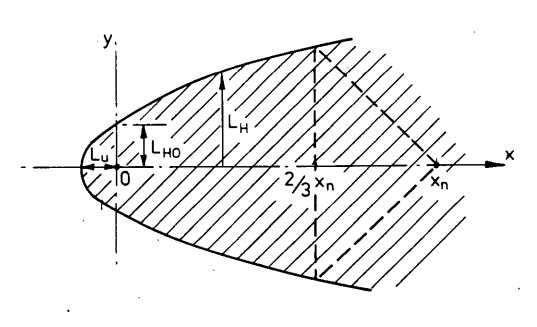

The Britter-McQuaid plume shape and dimensions.
:::

Instead of that I am going to use a simple rule-of-thumb for small plumes

$$ V_{PES} = 0.03 x_{\frac{1}{2}LFL}^3 $$

where $V_{PES}$ is the volume of the *potential explosion site*. In general this more than just the volume of a plume dispersing in open space, since buildings and equipment can confine the cloud and create multiple potential explosion sites of various sizes. This is a simple rule-of-thumb for screening purposes only

In [17]:
Vₚₑₛ = 0.03 * xᵢ^3

136857.23663150807

## Vapour Cloud Explosion

There are several parameters that can be estimated to characterize explosions with the positive overpressure perhaps being the most useful for simple screening cases. Tables exist relating different levels of positive overpressure to possible damage of nearby structures.

| psi   | kPa         | Damage                                                | 
|:-----:|:-----------:|-------------------------------------------------------| 
| 0.02  | 0.14        | Annoying noise                                        | 
| 0.04  | 0.28        | Loud noise, sonic boom, glass failure                 | 
| 0.15  | 1.03        | Typical pressure for glass breakage                   | 
| 0.4   | 2.76        | Limited minor structural damage                       | 
| 1     | 6.9         | Partial demolition of houses, made uninhabitable      | 
| 2 - 3 | 13.8 - 20.7 | Concrete or cinder block walls, not reinforced, shattered | 
| 3     | 20.7        | Steel framed buildings distorted and pulled away from foundations | 
| 4     | 27.6        | Cladding of light industrial buildings ruptured       | 
| 5     | 34.5        | Wooden utility poles snapped                          | 
| 7     | 48.2        | Loaded train wagon overturned                         | 
| 10    | 68.9        | Probable total destruction of buildings               | 

It's worth taking a moment to talk briefly about [deflagrations](https://en.wikipedia.org/wiki/Deflagration) and [detonations](https://en.wikipedia.org/wiki/Detonation). Deflagrations are characterized by subsonic flame propagation where the reaction zone moves through the flammable vapour by diffusion of heat and mass. Deflagrations typically result in relatively modest overpressures. A detonation, on the other hand, is characterized by a supersonic flame propagation and the reaction zone propagates by a pressure wave compressing the flammable vapour adiabatically to a temperature above the autoignition temperature. Detonations typically have significantly higher overpressures than deflagrations. Typically vapour cloud explosions in an open space with little congestion are deflagrations, however confinement and obstacles in the flame path can can accelerate a subsonic deflagration into a supersonic detonation. This is one reason why confinement and obstacles around a potential explosion site are important in the calculations.

The simplest way of calculating the overpressure is the TNT model, where the volume previously defined is used to estimate a potential explosion energy in TNT equivalents and this is compared to blast curves for TNT. For most major vapour cloud explosion incidents the TNT equivalences have been estimated to be from 1-10% of the full energy content of the cloud.

This is conceptually simple but can lead to very conservative estimates as vapour clouds, basically, don't explode like TNT. These methods typically overestimate pressure close to the explosion source and underestimate it far afield. Even though the TNT method is generally not recommended, at least not in any of the references I have, it is still used in some places and it does crop up.

A better approach is to use blast curves specifically for VCEs, in this case I am using the Baker-Strehlow-Tang curves but there are others.

### Explosive Energy

There are several ways of estimating explosive energy and all depend, in some way, on the size of the vapour cloud. Supposing the vapour cloud explosion is a deflagration and the energy in the explosion, fundamentally, comes from the combustion of the butane in the cloud then the energy can be found by estimating how much butane will combust and multiplying that by the heat of combustion of butane.

In some references the entire volume of the cloud will be assumed butane, but that can be excessively conservative -- we are assuming the edge of the cloud to be 1/2 LFL or ~0.93% (v/v) butane so assuming it to be 100% butane in that region is a serious over-estimate.

An alternative method[@ccps-2010] is to assume the cloud overall is at stoichiometric conditions. That is find the value of the stoichiometric concentration $\eta$


$$ \eta = { \textrm{moles fuel} \over \textrm{moles fuel + air} } = { n_f \over { n_f + \frac{n_o}{f_o} } } $$

where $n_f$ is the moles of fuel, $n_o$ the moles of oxygen, and $f_o$ the mole fraction of oxygen in air, 20.946%. For the combustion of n-butane

$$ C_{4} H_{10} + \frac{13}{2} O_{2} \longrightarrow 4 C O_{2} + 5 H_{2} O$$

and so for $n_f = 1$ we have $n_o = 6.5$

In [18]:
η = 1 / (1 + 6.5/0.20946)

0.031218607756809045

Using the ideal gas law the total moles of gas in the cloud can be estimated

$$ n_c = { { p_a V_{PES} } \over { R T_c } }$$

and the explosive energy is then

$$ E_{PES} = \eta n_c \Delta H_c $$

In [19]:
nc = ( pₐ * Vₚₑₛ )/(R * Tc)

Eₚₑₛ = η * nc * ΔHc

5.0778644110258764e8

### The BST model

The Baker-Strehlow-Tang model provides a series of correlation curves for different flame speeds and relates the positive overpressure to an energy scaled distance. The curves are based on spherical explosions and so it is important to include ground reflection when calculating the scaled distance.

The positive overpressure used in the BST model is a dimensionless pressure

$$ P = { { p - p_a } \over p_a } $$

where $p$ is the positive overpressure and $p_a$ the atmospheric pressure. This is correlated to the scaled distance

$$ R = r \cdot \left( p_a \over E \right)^{1/3} $$

where $E$ is the explosive energy and $r$ the distance from the explosion epicentre. Which in this case we can take as the centre of the cloud and estimate to be half-way to $x_i$

A spreadsheet with the BST curves is provided along with the AIChE/CCPS *Guidelines for Chemical Process Quantitative Risk Analysis*[@ccps-2000] from which I've extracted just the positive overpressure curves as a csv.

In [20]:
bst_curves = CSV.read("data/BST-curves.csv", DataFrame)

# just show the first 5 rows
first(bst_curves, 5)

,Mf,Scaled Distance,Overpressure
,Float64,Float64,Float64
1,0.037,0.010179,0.0100961
2,0.037,0.0104867,0.0100271
3,0.037,0.0108027,0.0100993
4,0.037,0.0111287,0.0101009
5,0.037,0.0114646,0.0101025


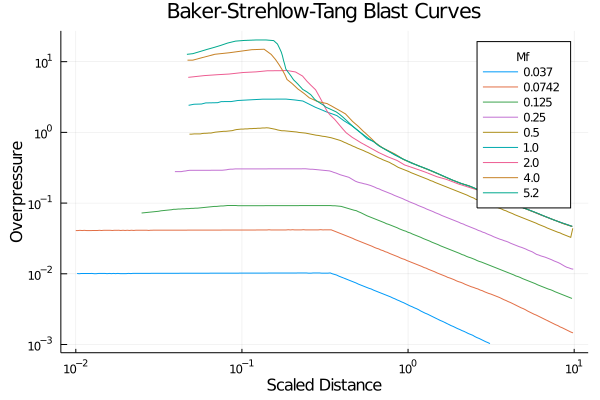

In [21]:
#| echo: false
#| label: fig-overpress
#| fig-cap: "The Baker-Strehlow-Tank overpressure curves"

flame_speeds = unique(bst_curves[!, "Mf"])

plot()

for speed in flame_speeds
    bst = bst_curves[ bst_curves."Mf" .== speed, :]
    plot!(bst[!, "Scaled Distance"], bst[!, "Overpressure"], lab=speed)
end

plot!(xlabel="Scaled Distance", ylabel="Overpressure", xscale=:log10, yscale=:log10)
plot!(title="Baker-Strehlow-Tang Blast Curves",
      legendtitle="Mf",
      legendtitlefontsize=8)

The following table[@ccps-2010] cross-references flame speed -- the key parameter of the BST curves -- with qualitative descriptors of fuel reactivity, density of surrounding process equipment, and degree of confinement

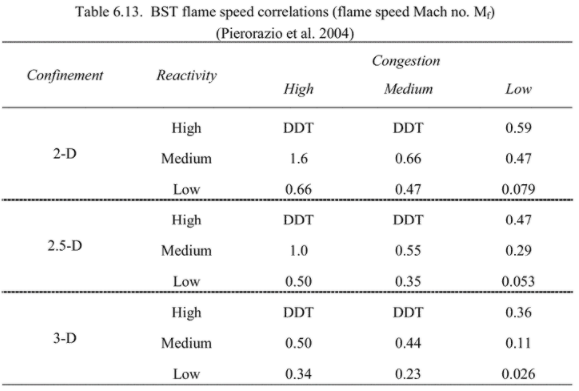

The dimensionality given is referencing the number of dimensions along which the pressure wave can travel. For example an explosion confined to a tunnel is considered one dimensional since the pressure wave can only travel along the tunnel, whereas an explosion in an open field is three dimensional since it can expand in all directions. The entries labeled *DDT* are where a deflagration to detonation transition may occur, due to the flame speed and potential congestion. In these cases it is recommended to use the $Mf = 5.2$ curve, sometimes referred to as the detonation blast curve.

| Dimension | Description  |
|:---------:|--------------|
| 3-D       | Unconfined volume, almost completely free expansion |
| 2.5-D     | Blockage partially prevents flame in one direction, such as piperacks with tightly packed pipes, lightweight roofs, or frangible panels |
| 2-D       | Platforms carrying process equipment, space beneath cars, open sided multistory buildings |
| 1-D       | Tunnels, corridors, or sewage systems |

For the storage sphere I am assuming it is standing freely on its own without any platforms or structures confining it, so the dimension is *3-D*

The density of surrounding equipment is defined qualitatively in terms of how much the surrounding area obstructs the expansion of the pressure wave. This can be defined in terms of the percentage of area in a plane occupied by obstacles.

| Type   | Blockage Ratio | Pitch for Obstacle Layers                           |
|:------:|:--------------:|-----------------------------------------------------|
| Low    |  &lt; 10%      | One or two layers of obstacles                      |
| Medium |  10 - 40%      | Two to three layers of obstacles                    |
| High   |  &gt; 40%      | Three of more fairly closely spaced obstacle layers |

For the storage sphere suppose that there is some process equipment nearby but it is not highly confined, defaulting to *medium*.

The fuel reactivity categories are defined in terms of the laminar burning velocity

| Reactivity | Laminar Burning Velocity | 
|:----------:|:------------------------:| 
| Low        |  &lt; 45 cm/s            | 
| Medium     |  45 - 75 cm/s            | 
| High       |  &gt; 75 cm/s            | 

The best resource for finding these tabulated is Appendix D of NFPA 68[@nfpa-2018]. For butane the laminar burning velocity is 45cm/s[@nfpa-2018 Table D.1(a)] and thus is *medium reactivity*

Returning to the table we find that the flame speed for a *medium reactivity fuel*, *medium obstacle density*, *3D case* is 0.44 (in terms of Mach number)

In [22]:
Mf = 0.44

0.44

*Note* the flame speeds given in the table do not correspond to the flame speeds given in the BST curves. In general one will have to double-interpolate to get the results. Find the curves that bracket the desired flame speed, interpolate to find the corresponding pair of overpressures at the given scaled distance then interpolate to find the overpressure at the desired flame speed.

The following code sets this up in an easy way, though probably a very sub-optimal one, by doing the following:

1. An interpolation function is created for each flame speed, these are stored in `bst_interps`
2. The function Δp₊ calculates the *positive* overpressure by stepping through the array `bst_interps` and calculating the overpressures at each tabulated flame speed for a given distance, then interpolates for the desired flame speed

In [23]:
bst_interps = []
flame_speeds = unique(bst_curves[!, "Mf"])

for speed in flame_speeds
    data = bst_curves[ bst_curves."Mf" .== speed, :]
    interp = LinearInterpolation(data[!, "Scaled Distance"], 
                                 data[!, "Overpressure"], 
                                 extrapolation_bc=Line())
    push!(bst_interps, (speed, interp))
end

In [24]:
"""
    Δp₊(r ; Mf=Mf, E=2*Eₚₑₛ, p₀=pₐ, curves=bst_interps)

Calculate the positive overpressure at distance r from the explosion epicentre.
The model parameters are the apparent flame speed, Mf, in terms of Mach number,
the explosion energy, E, and the atmospheric pressure p₀. The units of E and p₀
must agree, e.g. kJ and kPa.

The Baker-Strehlow-Tang curves are supplied through the curves keyword.
"""
function Δp₊(r ; Mf=Mf, E=2*Eₚₑₛ, p₀=pₐ, curves=bst_interps)
    E = 1000*E # Energy must be in J
    R = r*(p₀/E)^(1/3)
    
    Mfs = []
    Ps = []
    
    for (speed, interp) in bst_interps
        push!(Mfs, speed)
        push!(Ps, interp(R))
    end
    
    P = LinearInterpolation(Mfs, Ps)
    
    return P(Mf)*p₀
    
end

Δp₊

This generates a new blast curve interpolated between the curves supplied with the BST model, as shown in the plot below. Though care should be taken when the curve is used outside the range of the original curves.

*Note* that the explosion energy is being multiplied by 2. This is to account for ground reflection as the BST curves are based on spherical explosions. In general the explosion energy is multiplied by a factor, which ranges from 1 to 2, to account for ground reflection where a factor of 2 is for explosions exactly at ground level and a factor of 1 is for explosions at significant elevation. The simpler and more conservative approach is to use a factor of 2.

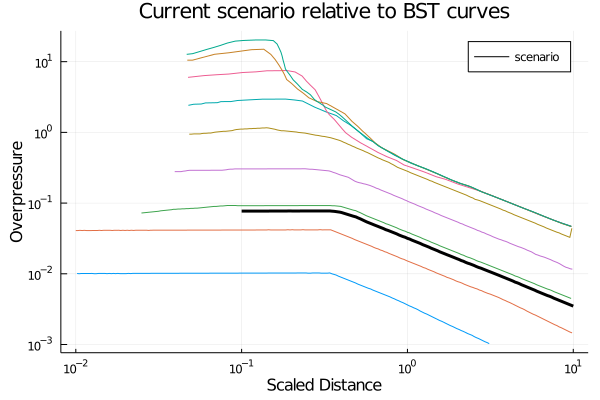

In [25]:
#| echo: false
#| label: fig-bst-scn
#| fig-cap: "The Baker-Strehlow-Tank overpressure curves with the current scenario indicated."

function overpressure(R; Mw=0.11, curves=bst_interps)   
    Mws = []
    Ps = []
    
    for (speed, interp) in bst_interps
        push!(Mws, speed)
        push!(Ps, interp(R))
    end
    
    P = LinearInterpolation(Mws, Ps)
    
    return P(Mw)
    
end

flame_speeds = unique(bst_curves[!, "Mf"])

plot()

for speed in flame_speeds
    bst = bst_curves[ bst_curves."Mf" .== speed, :]
    plot!(bst[!, "Scaled Distance"], bst[!, "Overpressure"], lab=false)
end

Rs = 0.1:.01:10
plot!(Rs, overpressure, line=3, lab="scenario", color=:black)
plot!(title="Current scenario relative to BST curves",
      xlabel="Scaled Distance", ylabel="Overpressure", 
      xscale=:log10, yscale=:log10)

The explosion epicentre is assumed to be the centre of the vapour cloud, here approximated to be half way between the release point and the downwind distance to 1/2 LFL, and in this simple model the explosion is a hemispherical pressure wave expanding in all directions unobstructed. More advanced modeling will take into account buildings and equipment and their impact on shaping the pressure wave.

The plot below shows the *maximum positive overpressure* experienced at that distance. Which is what is typically tabulated for different types of consequences. In general when I refer to *overpressure* this is what I am referring to.

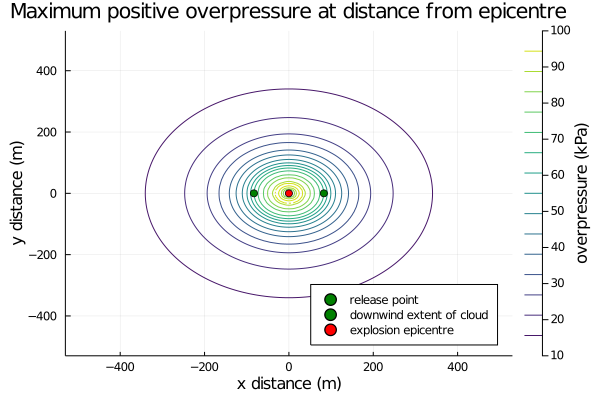

In [26]:
#| echo: false
#| label: fig-blast-contours
#| fig-cap: "The overpressure contours for the given example, showing the maximum overpressure experienced at the location."

xs = -500:5:500
ys = -500:5:500

function plots_Δp₊(x, y)
    r = √(x^2 + y^2)
    if r ≤ 5
        return Δp₊(5)/1000
    else
        return Δp₊(r)/1000
    end
end

contour(xs, ys, plots_Δp₊,
        c=:viridis, fill=false,
        clim=(10, 100), colorbar_title="overpressure (kPa)")
plot!([-0.5*xᵢ], [0.0], seriestype=:scatter, lab="release point", color=:green)
plot!([0.5*xᵢ], [0.0], seriestype=:scatter, lab="downwind extent of cloud", color=:green)
plot!([0.0], [0.0], seriestype=:scatter, lab="explosion epicentre", color=:red)
plot!(title="Maximum positive overpressure at distance from epicentre",
      ylabel="y distance (m)",
      xlabel="x distance (m)",
      leg=:bottomright)

### Sensitivity

A useful question to ask at this point is how sensitive is the predicted overpressure to the parameters of the model.

The figure below shows the impact of varying reactivity, while holding all other parameters constant. Clearly whether or not the explosion is treated as a detonation or deflagration matters hugely, the high reactivity curve corresponds to a detonation. The difference between a medium and low reactivity material is a approximately a factor of 4 in terms of max overpressure. So finding an appropriate value of reactivity while not being overly conservative is important.

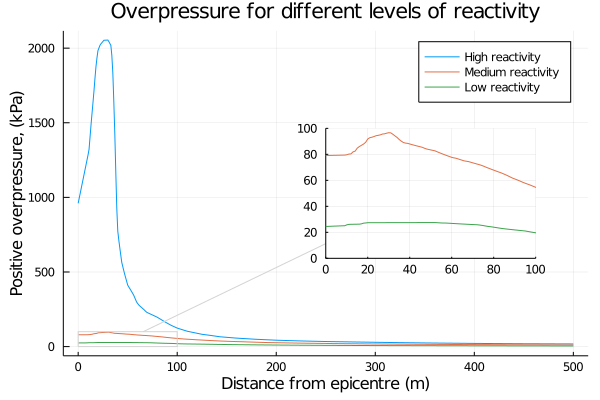

In [27]:
#| echo: false
#| label: fig-sens-react
#| fig-cap: "The sensitivity of the overpressure curve to reactivity."

rs = 0:1:500

plot(rs, r -> Δp₊(r, Mf=5.2)/1000, lab="High reactivity")
plot!(rs, r -> Δp₊(r, Mf=0.44)/1000, lab="Medium reactivity")
plot!(rs, r -> Δp₊(r, Mf=0.23)/1000, lab="Low reactivity")
plot!(title="Overpressure for different levels of reactivity",
      xlabel="Distance from epicentre (m)", 
      ylabel="Positive overpressure, (kPa)")
lens!([0, 100], [0, 100], inset = (1, bbox(0.5, 0.3, 0.4, 0.4)))


The following figure shows the impact of varying the levels of congestion. There is a fair amount of sensitivity going from low to medium but less from medium to high, which is perhaps what you would expect. I think the somewhat strange shape of the peaks is an artifact of linear interpolation.

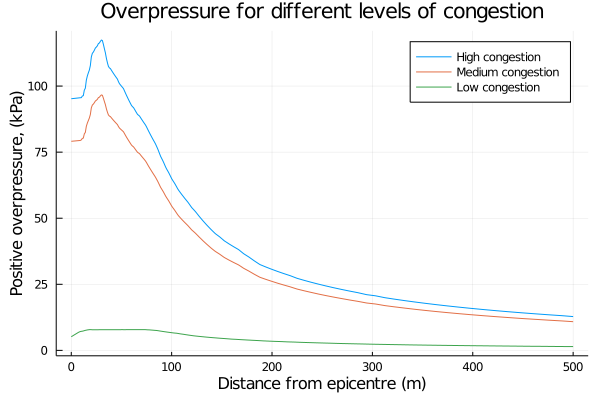

In [28]:
#| echo: false
#| label: fig-sens-cong
#| fig-cap: "The sensitivity of the overpressure curve to levels of congestion."

plot(rs, r -> Δp₊(r, Mf=0.50)/1000, lab="High congestion")
plot!(rs, r -> Δp₊(r, Mf=0.44)/1000, lab="Medium congestion")
plot!(rs, r -> Δp₊(r, Mf=0.11)/1000, lab="Low congestion")
plot!(title="Overpressure for different levels of congestion",
      xlabel="Distance from epicentre (m)",
      ylabel="Positive overpressure, (kPa)")

As is clear from the figure below the results are much less sensitive to changes in the level of confinement. At least while neglecting the one dimensional case, which should always be treated as a special case regardless.

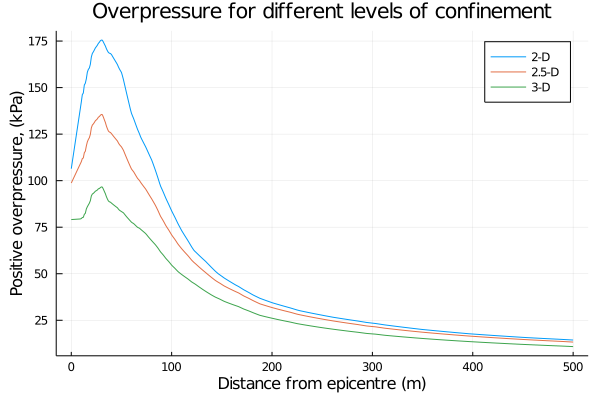

In [29]:
#| echo: false
#| label: fig-sens-conf
#| fig-cap: "The sensitivity of the overpressure curve to levels of confinement."

plot(rs, r -> Δp₊(r, Mf=0.66)/1000, lab="2-D")
plot!(rs, r -> Δp₊(r, Mf=0.55)/1000, lab="2.5-D")
plot!(rs, r -> Δp₊(r, Mf=0.44)/1000, lab="3-D")
plot!(title="Overpressure for different levels of confinement",
      xlabel="Distance from epicentre (m)",
      ylabel="Positive overpressure, (kPa)")

The last parameter worth investigating is the explosive energy, a significant portion of this exercise was in estimating the size of the vapour cloud and the consequent explosive energy. As is clear from the following figure the model is much less sensitive to changes in the explosive energy than the other parameters.

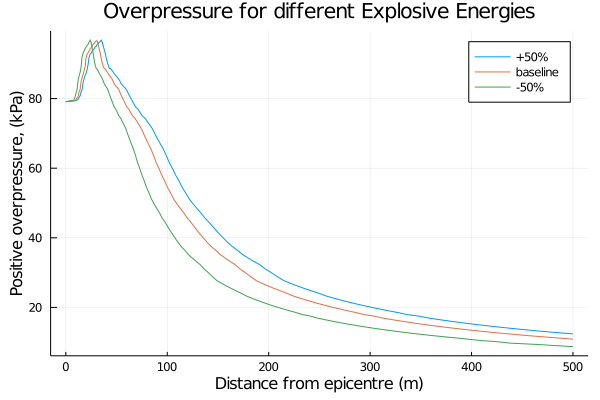

In [30]:
#| echo: false
#| label: fig-sens-expl
#| fig-cap: "The sensitivity of the overpressure curve to +/- 50% change in explosive energy"

plot(rs, r -> Δp₊(r, E=1.5*(2*Eₚₑₛ))/1000, lab="+50%")
plot!(rs, r -> Δp₊(r, E=1.0*(2*Eₚₑₛ))/1000, lab="baseline")
plot!(rs, r -> Δp₊(r, E=0.5*(2*Eₚₑₛ))/1000, lab="-50%")
plot!(title="Overpressure for different Explosive Energies",
      xlabel="Distance from epicentre (m)",
      ylabel="Positive overpressure, (kPa)")

## References
::: {#refs}
:::